In [234]:
import numpy as np
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt

In [235]:
%matplotlib inline
%matplotlib nbagg

## Oscilateur  'Masse In A Box'
### Mise en equation et formalisme de résolution

Generic motion equation written in the referenciel linked to the moving masse  :

$$
m \ddot{x} + \mu \dot{x} + k x = d
$$

$$
 \ddot{x} + \frac{\mu}{m} \dot{x} + \frac{k}{m} x = \frac{d}{m}
$$


### Potentiel Elastique

In [236]:
class Potential_linear():
    """
    Potentiel Elastique de la form k*x**2
    """
    def __init__(self, **kwargs):
        self.coeff = np.array([.5,0,0])
        self.update()
        
    def set_k(self,k=1):
        self.coeff[-3] = k/2.
        self.update()
    
    def get_k(self):
        return self.coeff[-3]
    
    def update(self):
        self.potential = np.poly1d(self.coeff)
        self.force     = self.potential.deriv()
    def __call__(self,x):
        return self.potential(x)
        
    def get_force(self,x):
        return self.force(x)
    
    def plot(self, label='', Diff2=True):
        x=np.linspace(-2,2,51)
        plt.plot(x,self(x), label=label+'Pot Elast')
        plt.plot(x,self.get_force(x), label=label+'1st diff (Force)')
        if Diff2:            
            plt.plot(x,self.force.deriv()(x), label=label+'2nd diff')
        plt.xlabel('x(s)')
        plt.grid('on')
        plt.legend()
        
        
class Potential_Duffing(Potential_linear):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.coeff = np.array([0,0,.5,0,0])
        self.update()
        
        
    def set_beta(self,beta=.1):
        self.coeff[-5] = beta/4
        self.update()
     

<IPython.core.display.Javascript object>


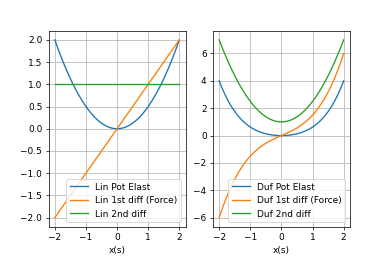

In [237]:
# Tracée du potentiel
pe = Potential_linear()
pe.set_k(1)

pduf = Potential_Duffing()
pduf.set_k(1)
pduf.set_beta(.5)

f=plt.figure()
plt.subplot(1,2,1)
pe.plot(label='Lin ')
plt.subplot(1,2,2)
pduf.plot(label='Duf ')

### Paysage de fréquence d'exitation

In [238]:
class sweep_freq():
    """
    Classe generic de création de donner temporelle à partire de donner de type (fréquence, Amplitude) variable
    """
    def __init__(self, t= np.linspace(0, 10, 200),
                 amp_tab = np.ones([3]),
                 w_tab = np.array([0, 1.,  1]),
                 t_tab = np.array([0, 5,  10]),**kwargs):
        self.t = t
        self.w_tab  = w_tab
        self.t_tab  = t_tab        
        self.amp_tab = amp_tab
        self.cumpute_int_wext()        

    def cumpute_int_wext(self):
        # cf : https://fr.wikipedia.org/wiki/Modulation_de_fr%C3%A9quence#Cas_g%C3%A9n%C3%A9ral
        wext_  = np.interp(self.t, self.t_tab, self.w_tab)
        #wext_ = wext_ + .3*np.random.randn(len(wext_))
        self.int_w = np.cumsum(wext_)*(self.t[1]-self.t[0])

    def __call__(self,ti):
        i = np.interp(ti, self.t, self.int_w)
        a = np.interp(ti, self.t_tab, self.amp_tab)
        rep = a * np.sin(i)
        return rep

<IPython.core.display.Javascript object>


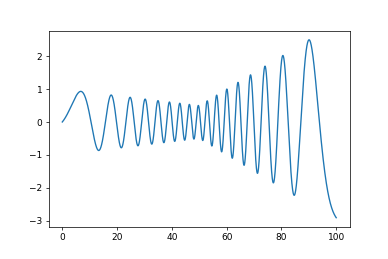

In [239]:
t = np.linspace(0, 100, 9000)
swf   = sweep_freq(t,w_tab=np.array([0.1, 2.,  .1]),
                   t_tab=np.array([0, 50,  100]),
                   amp_tab = np.array([1, .5,  3]))
plt.figure()
plt.plot(t,swf(t))

In [240]:
class sweep_freq_ramp(sweep_freq):
    """
    Classe de création de donner temporelle reproduissant un balayage en fréquence
    """
    def __init__(self,t, w_init=0,w_stab=1., t_stab = 5,amp=1., **kwargs):
        w_tab = np.array([w_init, w_stab,  w_stab])
        t_tab = np.array([t[0], t_stab,  t[-1]])
        amp_tab = amp * np.ones_like(w_tab)
        super().__init__(t=t,
                         w_tab= w_tab,
                         t_tab = t_tab,
                         amp_tab = amp_tab,**kwargs)
    
    
    def set_w_stab(self, w_stab):
        self.w_tab[1]=w_stab
        self.w_tab[2]=w_stab
        self.cumpute_int_wext()   
    
 

<IPython.core.display.Javascript object>


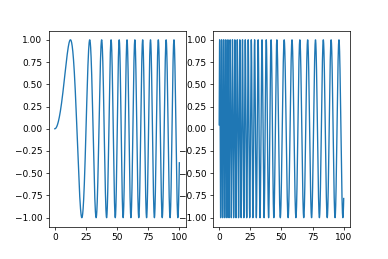

In [241]:
t = np.linspace(0, 100, 9000)

swfup = sweep_freq_ramp(t, t_stab = 50, w_init=0, w_stab=1.)
swfdw = sweep_freq_ramp(t, t_stab = 50, w_init=4, w_stab=1.)

plt.figure()
plt.subplot(1,2,1)
plt.plot(t,swfup(t))
plt.subplot(1,2,2)
plt.plot(t,swfdw(t))

## Oscilateur : 

In [355]:
class oscilateur():
    """
    Resolution dans le domain temporel des equations de l'oscilateur
    """
    def __init__(self, potential = None, acc_ext = None, mu=1.):
        self.pot = potential
        self.acc_ext = acc_ext
        self.m  = 1.
        self.mu = mu
        
    def _diff(self, t,X):
        x,xp = X
        m  = self.m
        mu = self.mu
        return np.array([xp, self.acc_ext(t)/m - mu/m * xp - self.pot.get_force(x)/m ])
    
    def set_acc_ext(self, acc_ext):
        self.acc_ext = acc_ext
    
    def get_w0(self):
        return np.sqrt(self.pot.get_k()/self.m)
    
    def run(self,t, tend=None):
        X0 = np.array([0.,0.])
        self.sol = solve_ivp(self._diff,[0.,t[-1]], X0, t_eval=t, method = 'DOP853', rtol=1e-6, atol=1e-6)
        xp = self.sol.y[1]        
        self.t=self.sol.t
        
        self.Ptrans = (self.mu * xp) * xp
        if tend==None:
            self.Ptrans_moy = (self.Ptrans[1:]*np.diff(t)).sum()/np.max(t)
        else:
            tend=int(tend)
            td=np.diff(t)
            Ptrans=self.Ptrans[1:]
            self.Ptrans_moy = (Ptrans[-tend:]*td[-tend:]).sum()/(t[-1]-t[-tend])
                
        
        return self.Ptrans_moy
    
    def plot(self, ax = None):
        sol = self.sol.y
        t = self.sol.t
        if ax is None:fig, ax = plt.subplots(1, 2, figsize=(8, 6))
        ax[0].plot(t, sol[1], 'r', label='$\dot x$')    
        ax[0].plot(t, sol[0], 'b', label='x')        
        ax[0].plot(t, self.Ptrans,'g', label='$P_trans [w]$')
        ax[0].legend(loc='best')
        ax[0].set_title('Puissance moyenne transmise (dissipée) : {0:0.3f} W'.format(self.Ptrans_moy))
        ax[0].set_xlabel('t(s)')
        ax[0].grid('on')
        
        #ax[1].set_ylim([-5,5])
        #ax[1].set_xlim([-5,5])        
        ax[1].plot(sol[0], sol[1], 'k')
        ax[1].set_xlabel('x(s)')
        ax[1].set_ylabel('$\dot x(s)$')
        ax[1].grid('on')
        return ax
    
    def fft(self,tend=100):
        tend=int(tend)
        sol = self.sol.y[0]
        sol = sol[-tend:]
        t = self.sol.t[-tend:]
        fft = np.fft.fft(sol)
        freq = np.fft.fftfreq(t.shape[-1])/(np.diff(t)[0])
        N=len(freq)
        return freq[0:N//2],abs(fft[0:N//2])
        
        

## Utilisation simple

<IPython.core.display.Javascript object>


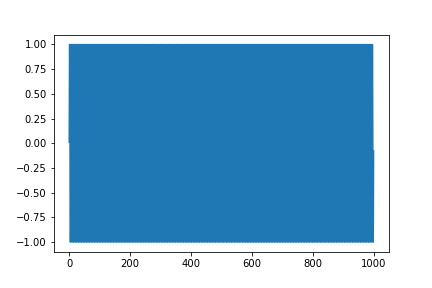

<IPython.core.display.Javascript object>


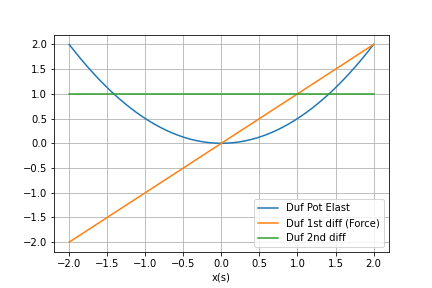

<IPython.core.display.Javascript object>


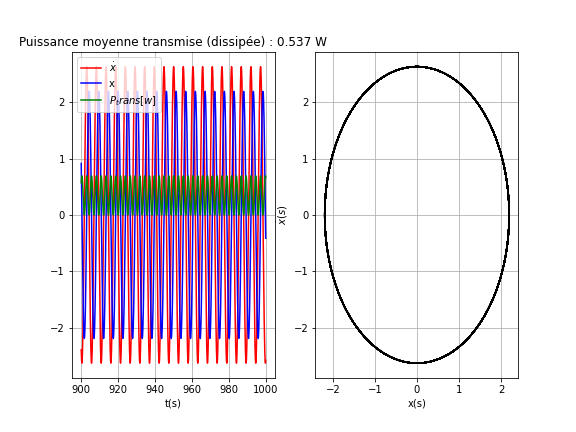

<IPython.core.display.Javascript object>


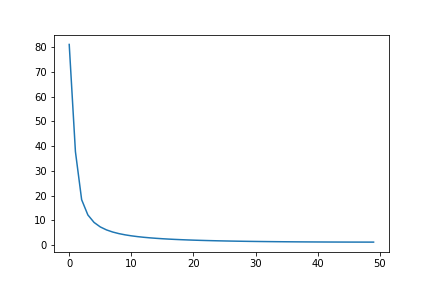

In [356]:
# Base de temps
t = np.linspace(0, 1000, 100000)
t_eval = np.linspace(900, 1000, 10000)

# Balayage en fréquence
w_stab=1.2
swfup = sweep_freq_ramp(t, w_init=w_stab, t_stab = 200, w_stab =w_stab, amp=1 )
plt.figure()
plt.plot(t,swfup(t))



#Défintion du potentielle elastique
pduf = Potential_Duffing()
pduf.set_k(1.)
pduf.set_beta(.0)

plt.figure()
pduf.plot(label='Duf ')

# construction de l'oscilateur
osc = oscilateur(potential = pduf, acc_ext = swfup, mu = 0.1)
osc.m=1.

# résolution
osc.run(t_eval, tend=100)
ax = osc.plot()
plt.show()

#FFT de la reponse
freq, amp = osc.fft()
plt.figure()
plt.plot(freq,amp)
plt.show()

### Puissance dissipée en fonction de $w_{ext}$

<IPython.core.display.Javascript object>


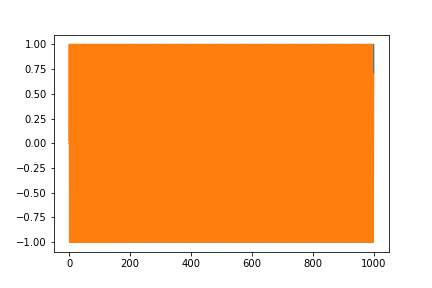

<IPython.core.display.Javascript object>


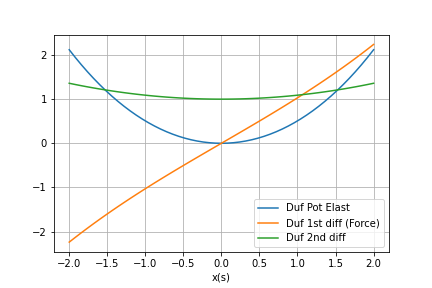

<IPython.core.display.Javascript object>


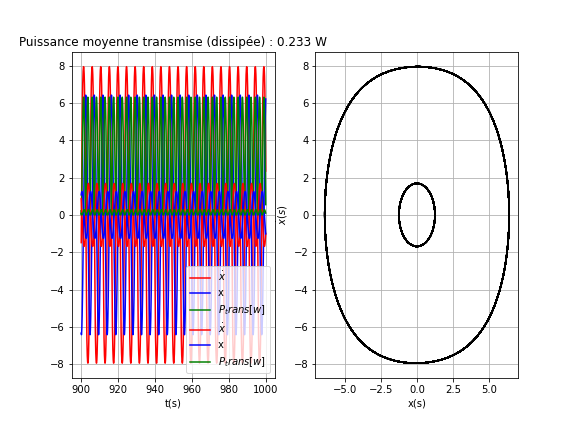

In [357]:
# Base de temps
t = np.linspace(0, 1000, (10000-1)*10)
t_eval = np.linspace(900, 1000, 10000-1)

# Balayage en fréquence
w_stab=1.35
swfup = sweep_freq_ramp(t, w_init=0., t_stab = 200, w_stab =w_stab )
swfdw = sweep_freq_ramp(t, w_init=3., t_stab = 200, w_stab =w_stab )
plt.figure()
plt.plot(t,swfup(t))
plt.plot(t,swfdw(t))


#Défintion du potentielle elastique
pduf = Potential_Duffing()
pduf.set_k(1.)
pduf.set_beta(.03)

plt.figure()
pduf.plot(label='Duf ')

# construction de l'oscilateur
osc = oscilateur(potential = pduf, acc_ext = swfup, mu = .1)
osc.m=1.

# run
osc.run(t_eval, tend=100)
ax = osc.plot()

osc.set_acc_ext(swfdw)
osc.run(t_eval, tend=100)
osc.plot(ax=ax)
plt.show()

In [358]:
# Test de différentes pulsation avec approche croissante et decroissante
w_stabs = np.linspace(1.2,1.45,50)

sweeps = [swfup, swfdw]
p = np.zeros((w_stabs.shape[0], len(sweeps)))
tend=int(9000)
ffts = np.zeros((len(w_stabs),len(sweeps) ,len(t[0:tend//2]) ))
j=0

for swf in sweeps:
    osc.set_acc_ext(swf)
    i=0
    for w_stab in w_stabs:
        swf.set_w_stab(w_stab)
        p[i,j]=osc.run(t_eval, tend=tend)
        freq, ffts[i,j,:]= osc.fft(tend=tend)
        i+=1        
    j+=1
   

<IPython.core.display.Javascript object>


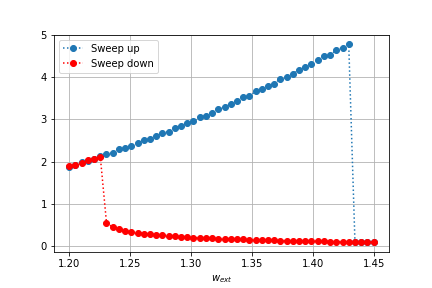

In [359]:
plt.figure()
plt.plot(w_stabs,p[:,0],'o:', label='Sweep up')
plt.plot(w_stabs,p[:,1],'ro:', label='Sweep down')
plt.xlabel('$w_{ext}$')
plt.legend()
plt.grid()
plt.savefig('Duf.pdf')

<IPython.core.display.Javascript object>


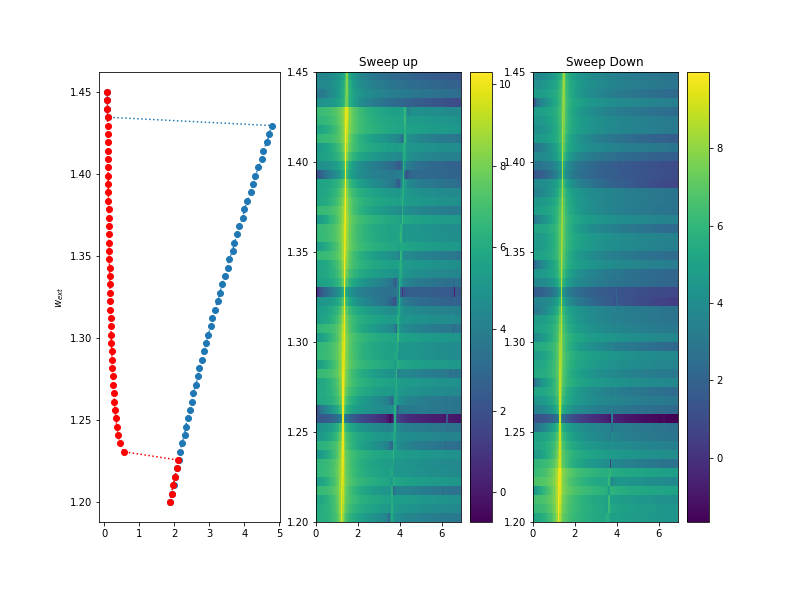

In [360]:
cutoff = 100
extent = np.min(2*np.pi*freq[0:cutoff]), np.max(2*np.pi*freq[0:cutoff]), np.min(w_stabs), np.max(w_stabs)

plt.figure()

plt.subplot(1,3,1)
plt.plot(p[:,0],w_stabs,'o:', label='Sweep up')
plt.plot(p[:,1],w_stabs,'ro:', label='Sweep down')
plt.ylabel('$w_{ext}$')

plt.subplot(1,3,2)
plt.imshow(np.log(ffts[:,0,0:cutoff]), aspect='auto', interpolation='nearest', origin='lower', extent=extent)
plt.colorbar()
plt.title('Sweep up')


plt.subplot(1,3,3)
plt.imshow(np.log(ffts[:,1,0:cutoff]), aspect='auto', interpolation='nearest', origin='lower', extent=extent)
plt.title('Sweep Down')
plt.colorbar()
plt.show()

<IPython.core.display.Javascript object>


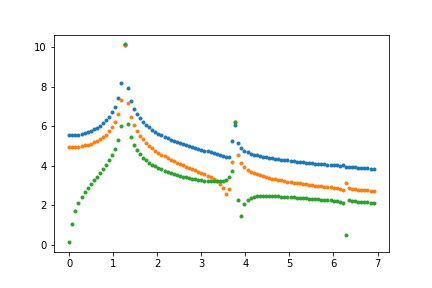

In [336]:
plt.figure()
for i in [49,50,51]:
    plt.plot(2*np.pi*freq[0:cutoff],np.log(ffts[i,0,0:cutoff]),'.')
    


In [321]:
t/np.diff(t)[0]

array([0.0000e+00, 1.0000e+00, 2.0000e+00, ..., 9.9987e+04, 9.9988e+04,
       9.9989e+04])

<IPython.core.display.Javascript object>


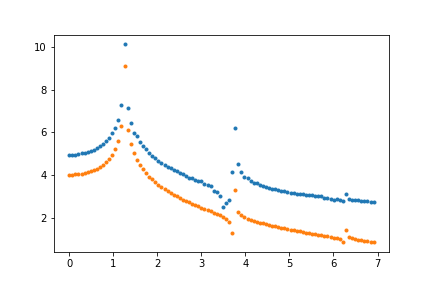

In [323]:
plt.figure()
plt.plot(2*np.pi*freq[0:cutoff],np.log(ffts[50,0,0:cutoff]),'.')
plt.plot(2*np.pi*freq[0:cutoff],np.log(ffts[50,1,0:cutoff]),'.')

## freq

In [167]:
len(freq[0:cutoff])



100

In [164]:
tend


10000